In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import autograd.numpy as np
from plot_tools import plot_contourf, plot_cost_function_3d, plot_evolution_charts, plot_cinematics_charts
from test_optimization_functions import Beale,saddle,Rose,Booth,Himme,Bukin,McCormick,be,Rastrigin,Ackley
from matplotlib.animation import FuncAnimation
from optimizers import Optimizer, run_optimizer
import math


In [2]:
#set the parameter
name='Beale'

iterations =2000

learning_rate = 1e-2

exec("cost_f = %s()"%(name))

In [3]:
# add optimizer
class Frankenstein(Optimizer):
    def __init__(self, cost_f, lr=0.001, x=None, y=None):
        super().__init__(cost_f, lr, x, y)
        self.m_x, self.m_y, self.s_x, self.s_y, self.t,self.vmax_x,self.vmax_y  = 0.0, 0.0, 1/lr,1/lr, 0,0,0
        
    def step(self, lr = None):
        self.t += 1
        if not lr:
            lr = self.lr        
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        
        beta=1.0-np.clip(0.1*np.sqrt(lr/1e-2),0.05,0.5)
        
        v_fx=np.arccos((np.tanh((dx*self.m_x))))/math.pi
        v_fy=np.arccos((np.tanh((dy*self.m_y))))/math.pi
        
        kkx=np.exp(-np.abs(self.s_x - v_fx))
        kky=np.exp(-np.abs(self.s_y - v_fy))
        
        dfcx =1.60653065971/(1.0+kkx)
        dfcy =1.60653065971/(1.0+kky)
        
        penx=dx*dx+1e-8
        peny=dy*dy+1e-8
        
        vmax_tx=np.maximum(self.vmax_x, penx)
        vmax_ty=np.maximum(self.vmax_y, peny)
        
        lr_tx=lr/np.sqrt(vmax_tx)*dfcx
        lr_ty=lr/np.sqrt(vmax_ty)*dfcy
        
        new_mx=self.m_x*np.log(np.clip(2.71828182846-v_fx+0.5
                , 0.81873075307,2.8010658347))
        new_my=self.m_y*np.log(np.clip(2.71828182846-v_fy+0.5
                , 0.81873075307,2.8010658347))
        
        new_mx = beta *new_mx -  dx * lr_tx
        new_my = beta*new_my -  dy * lr_ty
        
        new_px = self.x +beta*new_mx  - dx* lr_tx
        new_py = self.y +beta*new_my  - dy* lr_ty
        
        self.x=new_px
        self.y=new_py
        
        self.m_x=new_mx
        self.m_y=new_my
        
        
        
        tempx=np.clip(penx/self.s_x,0,1)*np.abs(v_fy-0.5)
        tempy=np.clip(peny/self.s_y,0,1)*np.abs(v_fy-0.5)
        
                
        self.vmax_x=vmax_tx*(1-tempx)+penx*(tempx)
        self.vmax_y=vmax_ty*(1-tempy)+peny*(tempy)
        

        self.s_x=penx
        self.s_y=peny
        return [self.x, self.y]
class SGD_nesterov_momentum(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, beta=beta)
        self.m_x, self.m_y=0,0
        
    def step(self, lr = None):
        if not lr:
            lr = self.lr        
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        beta = self.beta
        
        self.m_x=self.m_x*beta-lr*dx
        self.m_y=self.m_y*beta-lr*dy
        
        self.x=self.x+self.m_x*beta-lr*dx
        self.y=self.y+self.m_y*beta-lr*dy
            
        return [self.x, self.y]
class RMSProp(Optimizer):
    def __init__(self, cost_f, lr=0.001, decay_rate=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, decay_rate=decay_rate)
        self.ms_x = 0
        self.ms_y = 0
        
    def step(self, lr=None, decay_rate=None):
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        if not decay_rate:
            decay_rate = self.decay_rate
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        self.ms_x = self.decay_rate * (self.ms_x) + (1-self.decay_rate)*dx**2
        self.ms_y = self.decay_rate * (self.ms_y) + (1-self.decay_rate)*dy**2
        self.x = self.x - (lr/(epsilon + np.sqrt(self.ms_x)))*dx
        self.y = self.y - (lr/(epsilon + np.sqrt(self.ms_y)))*dy
        
        return [self.x, self.y]
class adabelief(Optimizer):
    def __init__(self, cost_f, lr=0.01, beta_1=0.9, beta_2=0.999, x=None, y=None):
        super().__init__(cost_f, lr, x, y, beta_1=beta_1, beta_2=beta_2)
        self.m_x, self.m_y, self.v_x, self.v_y, self.t  = 0, 0, 0, 0, 0
        
    def step(self, lr = None):
        self.t += 1
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        self.m_x = self.beta_1*self.m_x + (1-self.beta_1)*dx
        self.m_y = self.beta_1*self.m_y + (1-self.beta_1)*dy
        self.v_x = self.beta_2*self.v_x + (1-self.beta_2)*((dx-self.m_x)**2)
        self.v_y = self.beta_2*self.v_y + (1-self.beta_2)*((dy-self.m_y)**2)
        
        m_x_hat = self.m_x/(1-self.beta_1**self.t)
        m_y_hat = self.m_y/(1-self.beta_1**self.t)
        v_x_hat = self.v_x/(1-self.beta_2**self.t)
        v_y_hat = self.v_y/(1-self.beta_2**self.t)

        self.x = self.x - (lr*m_x_hat)/(np.sqrt(v_x_hat)+epsilon)
        self.y = self.y - (lr*m_y_hat)/(np.sqrt(v_y_hat)+epsilon)
        return [self.x, self.y]
class adam(Optimizer):
    def __init__(self, cost_f, lr=0.01, beta_1=0.9, beta_2=0.999, x=None, y=None):
        super().__init__(cost_f, lr, x, y, beta_1=beta_1, beta_2=beta_2)
        self.m_x, self.m_y, self.v_x, self.v_y, self.t  = 0, 0, 0, 0, 0
        
    def step(self, lr = None):
        self.t += 1
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        self.m_x = self.beta_1*self.m_x + (1-self.beta_1)*dx
        self.m_y = self.beta_1*self.m_y + (1-self.beta_1)*dy
        self.v_x = self.beta_2*self.v_x + (1-self.beta_2)*(dx**2)
        self.v_y = self.beta_2*self.v_y + (1-self.beta_2)*(dy**2)
        
        m_x_hat = self.m_x/(1-self.beta_1**self.t)
        m_y_hat = self.m_y/(1-self.beta_1**self.t)
        v_x_hat = self.v_x/(1-self.beta_2**self.t)
        v_y_hat = self.v_y/(1-self.beta_2**self.t)

        self.x = self.x - (lr*m_x_hat)/(np.sqrt(v_x_hat)+epsilon)
        self.y = self.y - (lr*m_y_hat)/(np.sqrt(v_y_hat)+epsilon)
        return [self.x, self.y]

In [4]:
# set up the optimizers
opt1=Frankenstein(cost_f=cost_f, lr=learning_rate)
opt2=adam(cost_f=cost_f, lr=learning_rate)
opt3=SGD_nesterov_momentum(cost_f=cost_f, lr=learning_rate, beta=0.9)
opt4=RMSProp(cost_f=cost_f, lr=learning_rate)
opt6=adabelief(cost_f=cost_f, lr=learning_rate)
opt=[opt1,opt2,opt3,opt4,opt6]

In [5]:
# optimizing
log_e=[]
log_d=[]
log_xs=[]
log_ys=[]


for i in range(len(opt)):
    e, d,xs, ys = run_optimizer(opt=opt[i], cost_f=cost_f, iterations=iterations)
    log_e.append(e)
    log_d.append(d)
    log_xs.append(xs)
    log_ys.append(ys)
    print(min(e))

5.3290705182006094e-15
7.893730103078821e-07
6.077401224278812e-07
7.222229503023531e-05
0.0


(-5.12, 5.12)

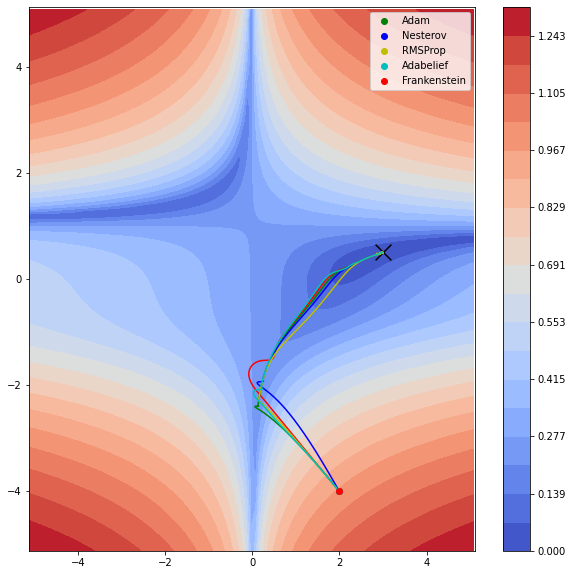

In [6]:
# plot result
import matplotlib.animation as animation

cb=['r','g','b','y','c']
fig, ax = plot_contourf(cost_f=cost_f, figsize=[10, 10], _show=False)


for i in range(len(opt)):
    plt.plot(log_xs[i],log_ys[i],c=cb[i])
    
o2, = plt.plot(log_xs[1][0],log_ys[1][0], 'go',label='Adam')
o3, = plt.plot(log_xs[2][0],log_ys[2][0], 'bo',label='Nesterov')
o4, = plt.plot(log_xs[3][0],log_ys[3][0], 'yo',label='RMSProp')
o6, = plt.plot(log_xs[4][0],log_ys[4][0], 'co',label='Adabelief')
o1, = plt.plot(log_xs[0][0],log_ys[0][0], 'ro',label='Frankenstein')

plt.legend()

ggt=iterations//100
def animate(i):
    
    o2.set_data(log_xs[1][:iterations][::ggt][i],log_ys[1][:iterations][::ggt][i])
    o3.set_data(log_xs[2][:iterations][::ggt][i],log_ys[2][:iterations][::ggt][i])
    o4.set_data(log_xs[3][:iterations][::ggt][i],log_ys[3][:iterations][::ggt][i])
    
    o6.set_data(log_xs[4][:iterations][::ggt][i],log_ys[4][:iterations][::ggt][i])
    o1.set_data(log_xs[0][:iterations][::ggt][i],log_ys[0][:iterations][::ggt][i])
    return o2,o3,o4,o1,o6


myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(iterations//ggt), \
                                      interval=10, blit=True, repeat=True)
    
plt.xlim(cost_f.xmin,cost_f.xmax)    
plt.ylim(cost_f.ymin,cost_f.ymax)    